## CS 131 Demo Day 

Peyton Chen
Fall 2021, Stanford University

Training and Test Eval Notebook

In [149]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import numpy as np
from PIL import Image


Downloaded dataset from here: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset, there are 10,000 training images and 10,000 test images as well as 800 validation images.

In [117]:
train_dir = 'dataset/Train'
test_dir = 'dataset/Test'
validation_dir = 'dataset/Validation'

# Need to resize images as they may be of different sizes and we want to standardize these as well as normalize these
# just like how we did in HW 8
train_dataset = ImageFolder(train_dir, transforms.Compose([transforms.Resize((150, 150)), 
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
test_dataset = ImageFolder(train_dir, transforms.Compose([transforms.Resize((150, 150)), 
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
validation_datset = ImageFolder(validation_dir, transforms.Compose([transforms.Resize((150, 150)), 
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
print(len(train_dataset))
print(len(test_dataset))
print(len(validation_datset))

OUTPUT_TO_LABEL = {0 : "WithMask", 1 : "WithoutMask"}

10000
10000
800


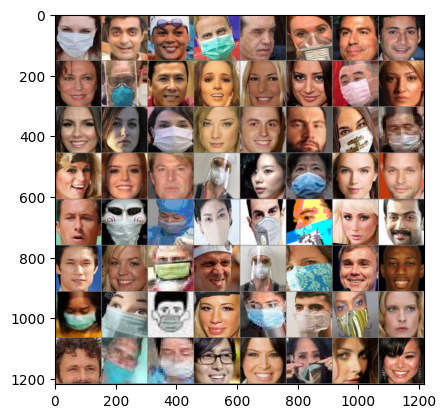

In [96]:
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()

import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [97]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.conv2 = nn.Conv2d(32, 32, (3,3))
        self.conv3 = nn.Conv2d(32, 32, (3,3))
        
        self.maxpool = nn.MaxPool2d((3,3))
        
        self.fc1 = nn.Linear(512, 100)
        self.fc2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [98]:
import torch.optim as optim
net = Net()
optimizer = optim.Adam(net.parameters())
criterion = nn.BCELoss()

In [99]:
epoch_num = 5
for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        labels = labels.to(torch.float32)

        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = torch.reshape(outputs, (-1,))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [11:24<00:00, 136.99s/it]


After training, save the model to local storage.

In [100]:
PATH = './face_mask.pth'
torch.save(net.state_dict(), PATH)

### Evaluating how the model has trained on one batch from test set

In [101]:
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
testdataiter = iter(testloader)
images, labels = testdataiter.next()

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
labels = labels.to(torch.float32)
outputs = torch.round(torch.reshape(outputs, (-1,)))

print(str(float((outputs == labels).sum().float() / batch_size) * 100) + '%')


100.0%


### Evaluating the model on all images from the test set

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        labels = labels.to(torch.float32)
        outputs = torch.round(torch.reshape(outputs, (-1,)))
        correct += (outputs == labels).sum()
        total += len(outputs)

In [106]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * int(correct) / int(total)))

Accuracy of the network on the 10000 test images: 99.37 %


### Evaluating the model on validation set

In [154]:
valloader = DataLoader(validation_datset, batch_size=batch_size, shuffle=True)
valdataiter = iter(valloader)

In [119]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)
        labels = labels.to(torch.float32)
        outputs = torch.round(torch.reshape(outputs, (-1,)))
        correct += (outputs == labels).sum()
        total += len(outputs)

In [121]:
print('Accuracy of the network on the 800 validation images: %.2f %%' % (
    100 * int(correct) / int(total)))

Accuracy of the network on the 800 validation images: 98.62 %


### Me as Test Subject

WithMask
tensor([[5.8882e-06]], grad_fn=<SigmoidBackward0>)


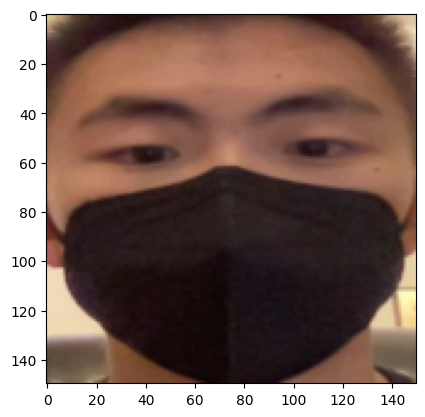

In [152]:
face = Image.open('temp.jpg')
transform = transforms.Compose([transforms.Resize((150, 150)), 
                            transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
transformed_img = transform(face)
output = net(transformed_img[None, ...])
print(OUTPUT_TO_LABEL[int(torch.round(output))])
print(output)

imshow(transformed_img)